In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [13]:
class stg_circuit:
    def __init__(self, dt=0.025, T=2400, fft_start=400, w=40):
        self.dt = dt
        self.T = T
        self.fft_start = fft_start
        self.w = w
        """V_m0 = -65.0e-3*np.ones((5,))
        N_0 = 0.25*np.ones((5,))
        H_0 = 0.1*np.ones((5,))
        self.init_conds = np.concatenate((V_m0, N_0, H_0), axis=0)"""
        self.init_conds = np.array([-0.04169771, -0.04319491,  0.00883992, -0.06879824,  0.03048103,
                                     0.00151316, 0.19784773, 0.56514935, 0.12214069, 0.35290397,
                                     0.08614699, 0.04938177, 0.05568701, 0.07007949, 0.05790969])

    def simulate(self, g_el, g_synA, g_synB):
        # define fixed parameters

        #conductances
        C_m = 1.0e-9

        # volatages
        V_leak = -40.0e-3 # 40 mV
        V_Ca = 100.0e-3 # 100mV
        V_k = -80.0e-3 # -80mV
        V_h = -20.0e-3 # -20mV
        V_syn = -75.0e-3 # -75mV

        v_1 = 0.0 # 0mV
        v_2 = 20.0e-3 # 20mV
        v_3 = 0.0 # 0mV
        v_4 = 15.0e-3 # 15mV
        v_5 = 78.3e-3 # 78.3mV
        v_6 = 10.5e-3 # 10.5mV
        v_7 = -42.2e-3 # -42.2mV
        v_8 = 87.3e-3 # 87.3mV
        v_9 = 5.0e-3  # 5.0mV

        v_th = -25.0e-3 # -25mV

        # neuron specific conductances
        g_Ca_f = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
        g_Ca_h = 1.7e-2 * (1e-6) # 1.7e-2 \mu S
        g_Ca_s = 8.5e-3 * (1e-6) # 8.5e-3 \mu S

        g_k_f  = 3.9e-2 * (1e-6) # 3.9e-2 \mu S
        g_k_h  = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
        g_k_s  = 1.5e-2 * (1e-6) # 1.5e-2 \mu S

        g_h_f  = 2.5e-2 * (1e-6) # 2.5e-2 \mu S
        g_h_h  = 8.0e-3 * (1e-6) # 8.0e-3 \mu S
        g_h_s  = 1.0e-2 * (1e-6) # 1.0e-2 \mu S

        g_Ca = np.array([g_Ca_f, g_Ca_f, g_Ca_h, g_Ca_s, g_Ca_s])
        g_k = np.array([g_k_f, g_k_f, g_k_h, g_k_s, g_k_s])
        g_h = np.array([g_h_f, g_h_f, g_h_h, g_h_s, g_h_s])

        g_leak = 1.0e-4 * (1e-6) # 1e-4 \mu S

        phi_N = 2 # 0.002 ms^-1

        def f(x, g_el, g_synA, g_synB):
            # x contains
            V_m = x[:5]
            N = x[5:10]
            H = x[10:]

            M_inf = 0.5*(1.0 + np.tanh((V_m - v_1)/ v_2))
            N_inf = 0.5*(1.0 + np.tanh((V_m - v_3)/v_4))
            H_inf = 1.0 / (1.0 + np.exp((V_m + v_5)/v_6))

            S_inf = 1.0 / (1.0 + np.exp((v_th - V_m) / v_9))

            I_leak = g_leak*(V_m - V_leak)
            I_Ca = g_Ca*M_inf*(V_m - V_Ca)
            I_k = g_k*N*(V_m - V_k)
            I_h = g_h*H*(V_m - V_h)

            I_elec = np.array([0.0,
                               g_el*(V_m[1]-V_m[2]),
                               g_el*(V_m[2]-V_m[1] + V_m[2]-V_m[4]),
                               0.0,
                               g_el*(V_m[4]-V_m[2])])

            I_syn = np.array([g_synB*S_inf[1]*(V_m[0] - V_syn),
                                g_synB*S_inf[0]*(V_m[1] - V_syn),
                                g_synA*S_inf[0]*(V_m[2] - V_syn) + g_synA*S_inf[3]*(V_m[2] - V_syn),
                                g_synB*S_inf[4]*(V_m[3] - V_syn),
                                g_synB*S_inf[3]*(V_m[4] - V_syn)])

            I_total = I_leak + I_Ca + I_k + I_h + I_elec + I_syn

            lambda_N = (phi_N)*np.cosh((V_m - v_3)/(2*v_4))
            tau_h = (272.0 - (-1499.0 / (1.0 + np.exp((-V_m + v_7) / v_8)))) / 1000.0

            dVmdt = (1.0 / C_m)*(-I_total + sigma_I*np.random.normal(0., 1., I_total.shape))
            dNdt = lambda_N*(N_inf - N)
            dHdt = (H_inf - H) / tau_h

            dxdt = np.concatenate((dVmdt, dNdt, dHdt), axis=0)
            return dxdt

        x = self.init_conds
        xs = [x]
        for t in range(self.T):
            dxdt = f(x, g_el, g_synA, g_synB)
            x = dxdt*self.dt + x
            xs.append(x)
        X = np.array(xs)

        return X

    def T_x(self, g_el, g_synA, g_synB):
        def moving_average(a, n=3) :
            ret = np.cumsum(a, dtype=float)
            ret[n:] = ret[n:] - ret[:-n]
            return ret[n - 1:] / n

        # sampling frequency
        Fs  = 1.0 / self.dt
        # num samples for freq measurement
        N = self.T - self.fft_start + 1 - (self.w-1)

        min_freq = 0.0
        max_freq = 1.0
        num_freqs = 101
        freqs = np.linspace(min_freq, max_freq, num_freqs)

        ns = np.arange(0,N)
        phis = []
        for i in range(num_freqs):
            k = N*freqs[i] / Fs
            phi = np.cos(2*np.pi*k*ns/N) - 1j * np.sin(2*np.pi*k*ns/N)
            phis.append(phi)

        Phi = np.array(phis)

        alpha = 50.

        X = self.simulate(g_el, g_synA, g_synB)
        v_h = X[self.fft_start:,2]

        v_h_rect = np.maximum(v_h, 0.0)
        v_h_rect_LPF = moving_average(v_h_rect, self.w)
        v_h_rect_LPF = v_h_rect_LPF - np.mean(v_h_rect_LPF)

        V_h = np.abs(np.dot(Phi, v_h_rect_LPF))
        V_h_pow = np.exp(alpha*V_h)
        freq_id = V_h_pow / np.sum(V_h_pow)

        freq = np.dot(freqs, freq_id)
        T_x = np.array([freq, np.square(freq)])
        return T_x

In [25]:
np.random.seed(0)

dt = 0.025
T = 200
fft_start = 0
w = 20

true_sys = stg_circuit(dt, T, fft_start, w=w)



(201, 5)


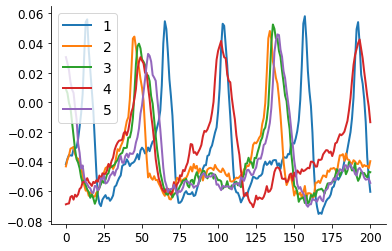

In [24]:
X = true_sys.simulate(6e-9, 2e-9, 2e-9)
T_x = true_sys.simulate(6e-9, 2e-9, 2e-9)
V = X[:,:5]
print(V.shape)
plt.plot(V)
plt.legend(np.arange(1,6))


In [20]:
g_els = np.arange(0.1, 8.0, 0.25) * (1e-9) # .25 nS  (.25-7.5 nS) range
g_synAs = np.arange(0.1, 4.0, 0.25) * (1e-9) # .25 nS  (.25-10 nS) range
g_synB = 2.0 * (1e-9) # .25 nS  (.25-10 nS) range
M = g_els.shape[0]
N = g_synAs.shape[0]
x_true = np.zeros((M,15,T+1))
T_x_true = np.zeros((M,N))
for i in range(M):
    g_el = g_els[i]
    for j in range(N):
        print("(%2d/%2d, %2d/%2d\r" % (i,M, j, N), end="")
        g_synA = g_synAs[j]
        T_x_true[i,j] = true_sys.T_x(g_el, g_synA, g_synB)[0]

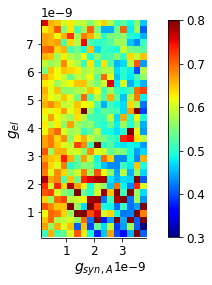

In [21]:
fontsize = 14
fig = plt.figure(figsize=(8,4))
plt.imshow(T_x_true, origin='lower', vmin=0.3, vmax=0.8, cmap='jet', extent=[g_synAs[0], g_synAs[-1], g_els[0], g_els[-1]])
ax = plt.gca()
plt.colorbar()
plt.xlabel(r'$g_{syn,A}$', fontsize=fontsize)
plt.ylabel(r'$g_{el}$', fontsize=fontsize)
plt.show()

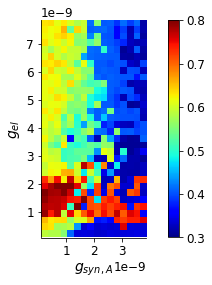

In [6]:
fontsize = 14
fig = plt.figure(figsize=(8,4))
plt.imshow(T_x_true, origin='lower', vmin=0.3, vmax=0.8, cmap='jet', extent=[g_synAs[0], g_synAs[-1], g_els[0], g_els[-1]])
ax = plt.gca()
plt.colorbar()
plt.xlabel(r'$g_{syn,A}$', fontsize=fontsize)
plt.ylabel(r'$g_{el}$', fontsize=fontsize)
plt.show()

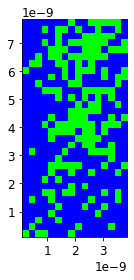

In [22]:
targ = 0.535
targ_std = 0.05
minval = targ - targ_std
maxval = targ + targ_std
th_inds = np.logical_and(T_x_true > minval, T_x_true < maxval)
plt.imshow(th_inds, origin='lower', cmap='brg', extent=[g_synAs[0], g_synAs[-1], g_els[0], g_els[-1]])




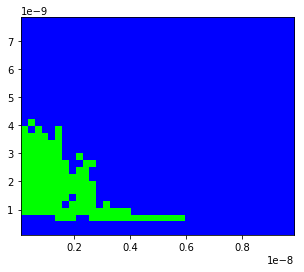

In [12]:
targ = 0.725
targ_std = 0.025
minval = targ - 2*targ_std
maxval = targ + 2*targ_std
th_inds = np.logical_and(T_x_true > minval, T_x_true < maxval)
plt.imshow(th_inds, origin='lower', cmap='brg', extent=[g_synAs[0], g_synAs[-1], g_els[0], g_els[-1]])




In [4]:
g_el = 1.0e-9
g_synA = 1.0e-9
T_x_fast = true_sys.T_x(g_el, g_synA, g_synB)

NameError: name 'true_sys' is not defined

In [ ]:
g_el = 1.0e-9
g_synA = 1.0e-9
x_fast = true_sys.simulate(g_el, g_synA, g_synB)

g_el = 4.0e-9
g_synA = 4.0e-9
x_slow = true_sys.simulate(g_el, g_synA, g_synB)

g_el = 6.0e-9
g_synA = 1.5e-9
x_med = true_sys.simulate(g_el, g_synA, g_synB)

t = np.arange(T+1) / dt
plt.figure()
plt.plot(t, x_fast[:,2], 'r')
plt.plot(t, x_slow[:,2], 'b')
plt.plot(t, x_med[:,2], 'g')
plt.show()

In [13]:
X = np.concatenate((x_fast, x_slow, x_med), axis=0)
print(X.shape)

(633, 15)


(633, 15)
[7.61614939e-02 3.77390392e-02 2.45284326e-02 1.33417613e-02
 8.02210892e-03 7.10844996e-04 5.54135760e-04 4.37961456e-04
 3.25643988e-04 1.90095502e-04 1.07925933e-04 7.83794627e-05
 4.10377289e-05 4.05002546e-05 1.05834210e-05]


<StemContainer object of 3 artists>

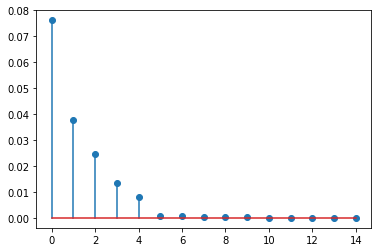

In [14]:
def PCA(data, dims_rescaled_data=2):
    """
    returns: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """
    import numpy as NP
    from scipy import linalg as LA
    m, n = data.shape
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = NP.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = LA.eigh(R)
    # sort eigenvalue in decreasing order
    idx = NP.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :dims_rescaled_data]
    # carry out the transformation on the data using eigenvectors
    # and return the re-scaled data, eigenvalues, and eigenvectors
    return NP.dot(evecs.T, data.T).T, evals, evecs

X_PCs, evals, evecs = PCA(X, 15)
print(X_PCs.shape)
print(evals)
plt.stem(evals)

['D=1', 'D=2', 'D=3', 'D=4', 'D=5']


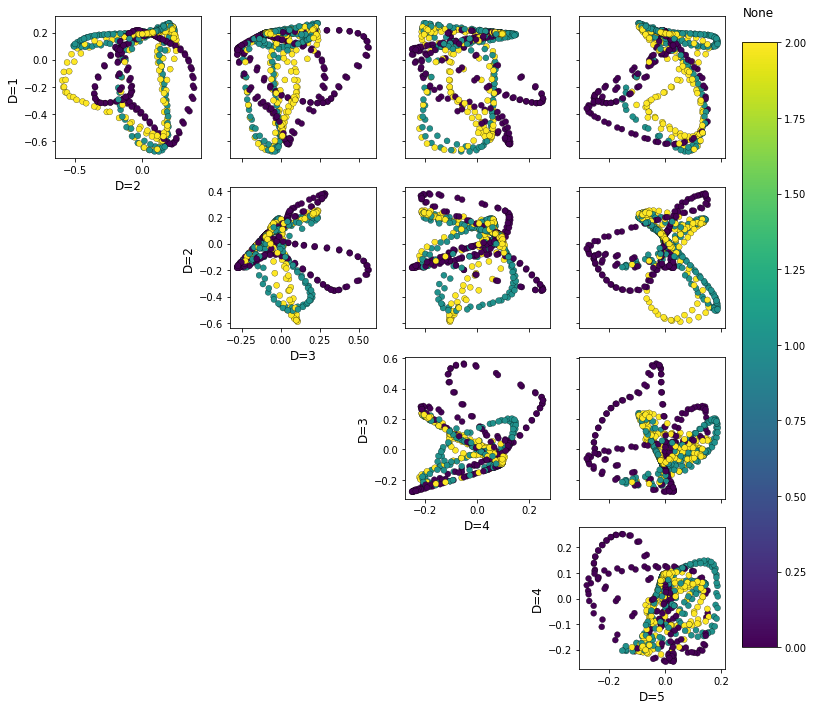

In [15]:
from dsn.util.plot_util import pairplot
X_PCs_fast = X_PCs[:(T+1),:]
X_PCs_slow = X_PCs[(T+1):,:]
X_PCs_med = X_PCs[2*(T+1):,:]
labels = ["D=%d" % i for i in range(1, 6)]
print(labels)
c = np.concatenate((np.zeros((T+1,)), np.ones((T+1,)), 2*np.ones((T+1,))), axis=0)
fig = pairplot(X_PCs, range(5), c=c, labels=labels)

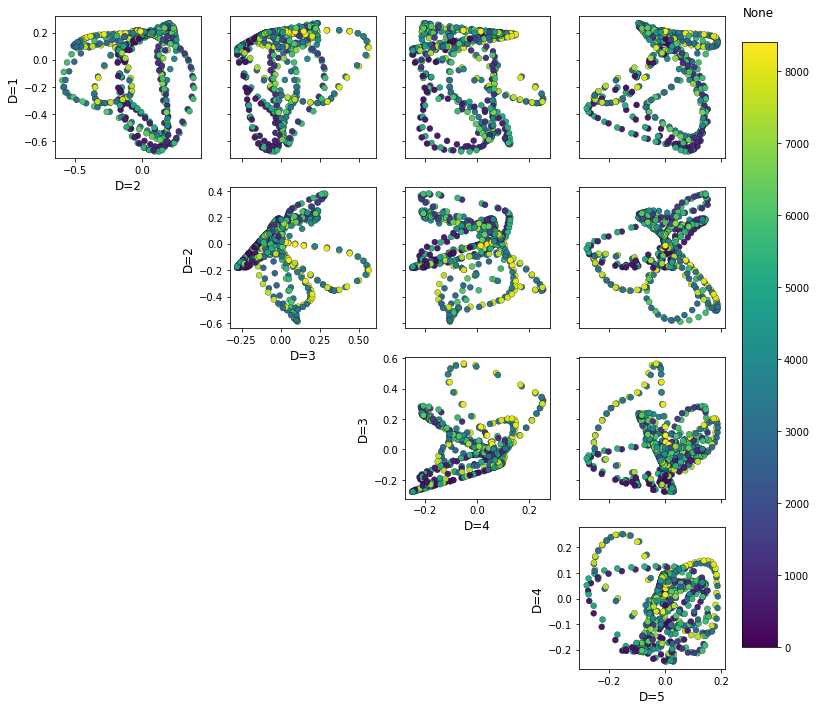

In [16]:
c = np.concatenate((t, t, t), axis=0)
fig = pairplot(X_PCs, range(5), c=c, labels=labels)

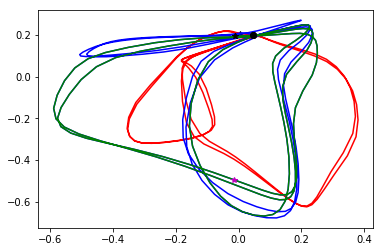

In [19]:
plt.plot(X_PCs_fast[:,1], X_PCs_fast[:,0], 'r')
plt.plot(X_PCs_fast[0,1], X_PCs_fast[0,0], 'ko')
plt.plot(X_PCs_fast[-1,1], X_PCs_fast[-1,0], 'k*')
plt.plot(X_PCs_slow[:,1], X_PCs_slow[:,0], 'b')
plt.plot(X_PCs_slow[0,1], X_PCs_slow[0,0], 'ko')
plt.plot(X_PCs_slow[-1,1], X_PCs_slow[-1,0], 'k*')
plt.plot(X_PCs_med[:,1], X_PCs_med[:,0], 'g')
plt.plot(X_PCs_med[0,1], X_PCs_med[0,0], 'ko')
plt.plot(X_PCs_med[-1,1], X_PCs_med[-1,0], 'k*')

init_time_ind = 85
plt.plot(X_PCs_med[init_time_ind,1], X_PCs_med[init_time_ind,0], 'm*')

In [20]:
print(x_med[init_time_ind])

[-0.04169771 -0.04319491  0.00883992 -0.06879824  0.03048103  0.00151316
  0.19784773  0.56514935  0.12214069  0.35290397  0.08614699  0.04938177
  0.05568701  0.07007949  0.05790969]
